In [10]:
# Change this line if you're using Colab to something like '/content/drive/MyDrive/TeamX/'
# where TeamX is just the clone of repository on your Google Drive
# and you have mounted the drive at /content/drive  
# See the Tutorial Slides for more detail.

# Works on your local machine but not on Colab!
PROJECT_ROOT = '../..' 

# Fix this path and use this one on Colab
# PROJECT_ROOT = '/content/drive/MyDrive/TeamX'

import sys
from os.path import join as ospj
sys.path.append(ospj(PROJECT_ROOT, 'src'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this part of assignment 4 we try to
1. implement the forward pass of ViT
2. visualize the attention weights for the final CLS Token.


For evaluation and visualization, we use an 8-class subset (out of 1000) of Imagenet-V2. We use a subset, simply just so that you can run the cells faster.
The model is pre-trained and you just need to download the weights.

Furthermore, most of the relevant modules for ViT, such as the positional embedding, the linear projection, MLP Block, and Multi-head attention are all already implemented. What you mainly have to do is to plug these modules together based on what you've seen in lecture 7 (the ViT slides).

You probably shouldn't need GPU for running this assignment, as there is no training and the dataset is very small and every cell. But of course feel free to change the notebook so that it works on GPU if desired.

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

from torchvision import datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm 

from models.vit.model import VisionTransformer
from utils.imagenet_names import name_map

## Downloading pre-trained weights

Please Download the weights from `https://download.pytorch.org/models/vit_b_16-c867db91.pth` and place it under `saved/models/vit/vit.pth`. The file size is 330M.


or you can just download and place it by running the cell below (tested on Linux).

In [12]:
#!wget "https://download.pytorch.org/models/vit_b_16-c867db91.pth"

# Change the relative paths below to absolute if running on Colab
#!mkdir -p ../../saved/models/vit
#!mv vit_b_16-c867db91.pth ../../saved/models/vit/vit.pth

## Q1: ViT Inference (15 points)

For this part you need to complete the missing parts of the ViT model. 

<img src="../../data/exercise-4/ViT.png" width=1400 />

There are overall 6 `TODO Q1`s to be implemented for this question. 

You can of course define new attributes in the classes if you find it necessary. However, you cannot define new modules *with parameters* or change the name modules with parameters.
Otherwise, the `load_state_dict` will fail to match the weight values in the file with the code. Also changing the configs such as number of layers or dimensions would cause the same mismatch in loading weights.



In [13]:
weights = torch.load(ospj(PROJECT_ROOT,'saved/models/vit/vit.pth'))

model = VisionTransformer(
            image_size=224, # Input image size (width and height)
            patch_size=16,  # Image broken into (16 x 16) non-overlaping batches
            num_layers=12,  # Number of blocks in the Encoder
            num_heads=12,   # Number of heads in each Multi-"head" attention
            hidden_dim=768, # Token size (length of a single token)
            mlp_dim=3072,   # Hidden layer size of each MLP layer
        )

model.load_state_dict(weights, strict=True)

<All keys matched successfully>

Create the Dataset

We're using only 8 classes of Imagenet-V2 for this assignment. Feel free to checkout the entire dataset (https://github.com/modestyachts/ImageNetV2).

In [14]:
# Since we're just using a subset of classes, the labels that ImageFolder generates (starting from 0 to 7) 
# should be converted back to correct (0 to 999) numbers.
def label_convert(idx):
    class_subset = sorted([19, 330, 466, 558, 672, 716, 755, 986,])
    return class_subset[idx] # e.g. 0 -> 19, 2 -> 466


t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),

        # Normalization is commented-out just for easier visualization below. Try putting it back if you failed the accuracy check.
        # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) 
    ]
)

dataset = datasets.ImageFolder(
        root=ospj(PROJECT_ROOT, 'data/exercise-4/Imagenet-V2-Subset'),
        transform=t, 
        target_transform=label_convert
    )
print(f"Test set is created with {len(dataset)} samples")

Test set is created with 80 samples


In [15]:
loader = DataLoader(
                dataset=dataset,
                drop_last=False,
                shuffle=False, 
                batch_size=16, # Change the batch size if the model doesn't fit into memory.
                num_workers=2,
        )

In [16]:
num_correct = 0
total_cnt = 0
model.eval()

with torch.no_grad():
    for batch_idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)):
        out, attention_weights = model(images)
        pred = out.argmax(dim=1)

        num_correct += (pred == targets).sum()
        total_cnt += len(images)

top1_acc = 100*num_correct/total_cnt

print(f"Top-1 Acc on Test set is {100 * num_correct/total_cnt}")
assert top1_acc == 83.75, 'Accuracy does not match the expected value!'

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it]

Top-1 Acc on Test set is 83.75


# Visualize the Attention

Pick an image!

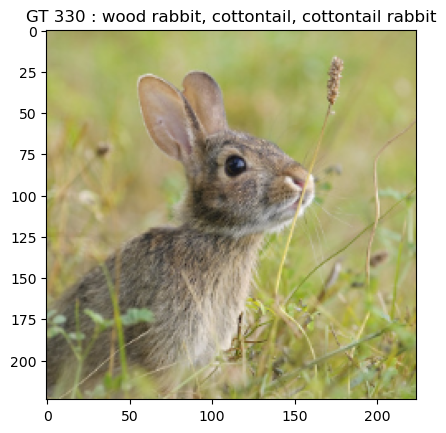

In [21]:
x, label = dataset[19]
plt.title(f"GT {label} : {name_map[label]}")
plt.imshow(x.moveaxis(0, -1))

Predicted class 330 : wood rabbit, cottontail, cottontail rabbit


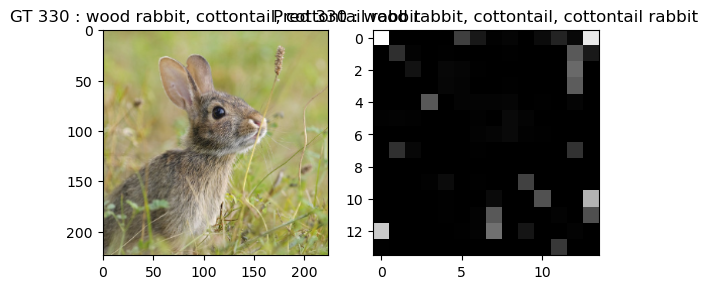

In [22]:
with torch.no_grad():
    output, attention_weights = model(x[None])

pred = output.argmax(dim=1).item()
print(f"Predicted class {pred} : {name_map[pred]}")

plt.subplot(1, 2, 1)
plt.imshow(x.moveaxis(0, -1))
plt.title(f"GT {label} : {name_map[label]}")
plt.subplot(1, 2, 2)
plt.imshow(attention_weights[0], cmap='gray')
plt.title(f"Pred {pred} : {name_map[pred]}")
plt.show()

## Please briefly answer the following based on your intuition. (10 points)
1. Why does the attention map have lower resolution?
2. Browse other samples of the dataset (simply change the idx above or add extra cells below). Is the attention map of final CLS token always localized on the object? Briefly explain your intuition behind what you see.
3. As mentioned above, we're visualizing the attention weights of the CLS token at the last layer.
   
   Can you think of any problems regarding this? 

   Can you come up with some other way of looking into a decision made by a transformer model?
   
   
#### Answers:
1. The attention map has a lower resolution as it works with the tokes instead of pixels. One token consists of multiple pixels so there are less tokens than pixels.
2. No not always, for example dataset[19], the attention points are not located on the object (a rabbit) at all, but outside of it. It can also be that the tranformer learned to identify a rabbit by the shape he cancels out of a field.
3. We are only seeing what is happening in the last layer and not what has led to this configuration of the last layer. A more in depth way to look into the decison would be to visualize the other layers aswell.
